In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ImageProcessing/CK/ImageSegmentation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ImageProcessing/CK/ImageSegmentation


In [ ]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# NumPy for numerical operations
import numpy as np

# PIL (Python Imaging Library) for image processing
from PIL import Image
import segmentation_models_pytorch as smp


# Matplotlib for data visualization
import matplotlib.pyplot as plt

# PyTorch DataLoader and Dataset utilities
from torch.utils.data import DataLoader, Dataset

# OS and shutil for file handling and directory operations
import os
import shutil

# Albumentations for advanced image augmentations
import albumentations as A

# PyTorch core modules for tensor operations and deep learning
import torch
import torch.nn as nn

# Torchvision for image transformations
import torchvision.transforms.functional as TF

# Albumentations ToTensorV2 for converting images to PyTorch tensors
from albumentations.pytorch import ToTensorV2

# Random module for generating random values (e.g., for augmentations)
import random

# TQDM for progress bar visualization during training
from tqdm import tqdm

# PyTorch optimizers for model training
import torch.optim as optim

In [ ]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# model.load_state_dict(torch.load("/kaggle/working/best_weights.pth"))  # Load saved weights
model = smp.from_pretrained('best_weights.pth')
model= model.to(DEVICE)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

Loading weights from local directory


In [ ]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

# Load và transform ảnh đầu vào (đảm bảo giống transform dùng trong test_loader)
image_path = "TestImg/diseasebanner.jpg"
image = Image.open(image_path).convert("RGB")

# Ví dụ transform giống như test_loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize ảnh nếu cần
    transforms.ToTensor(),          # chuyển ảnh thành tensor
])

input_tensor = transform(image).unsqueeze(0)  # Thêm batch dimension: (1, C, H, W)
input_tensor = input_tensor.to(DEVICE)

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    output = torch.sigmoid(output)

# Nếu là segmentation, output sẽ có shape (1, 1, H, W)
# Nếu là classification, output có shape (1, 1)
# Áp dụng threshold:
threshold = 0.5
binary_pred = (output > threshold).float()

# Chuyển kết quả về CPU để xử lý hoặc hiển thị
binary_pred_np = binary_pred.cpu().numpy()

print(binary_pred_np)


[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]


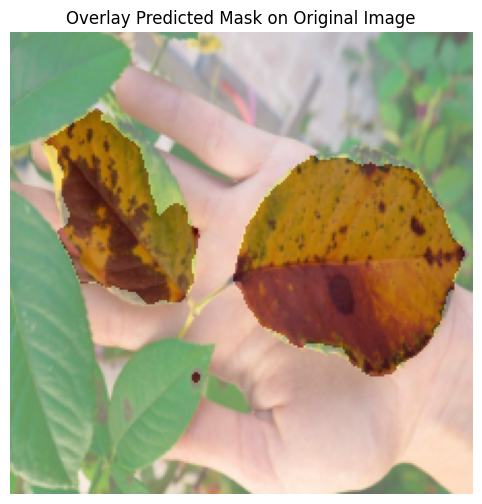

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Chuyển ảnh input từ tensor về numpy, shape (H, W, C)
img_np = input_tensor.squeeze(0).cpu().numpy()
img_np = np.transpose(img_np, (1, 2, 0))

# Dự đoán mask nhị phân
pred_mask_np = binary_pred.squeeze().cpu().numpy()  # shape: (H, W)

# Tạo overlay màu đỏ cho vùng dự đoán
overlay = img_np.copy()
overlay[pred_mask_np > 0.5] = [1.0, 0.0, 0.0]  # tô đỏ vùng mask

# Hiển thị ảnh gốc với mask overlay
plt.figure(figsize=(12, 6))
plt.imshow(img_np)
plt.imshow(pred_mask_np, cmap='Reds', alpha=0.4)  # alpha là độ trong suốt
plt.title("Overlay Predicted Mask on Original Image")
plt.axis('off')
plt.show()
